Author: https://github.com/pyautoml

You  need install these libraries to run the code:
pip install numpy pandas seaborn kagglehub wordcloud imbalanced-learn --quiet

# Links and resources
1. Email spam dataset for this lesson: https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset
2. A great article to read more about resampling strategies: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification

# Vectorizing Text Data for Machine Learning

- We explore the process of transforming text data into meaningful input for machine learning models using various vectorizing techniques.
- Vectorized data or vectorized whole documents are often used for efficient ranked data retrieval. For instance, passing only relevant data to an LLM model via RAG.
- The primary focus is building a system to classify emails as spam or not, giving you hands-on experience with practical applications of text processing. 

- Glossary:
    - term: a word that has a meaning (e.g. is not a stopword)
    - documents: email subject and content
    - corpus: (similar to linguistic corpora) unique words across all documents (in this case, all emails)

In [1]:
#%pip install numpy
#%pip install pandas
#%pip install seaborn
#%pip install kagglehub
#%pip install wordcloud
#%pip install imbalanced-learn

In [2]:
import os
import nltk
import math
import torch
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from typing import Any, List, Tuple
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from collections import defaultdict, Counter
from nltk.stem.snowball import EnglishStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# helper function
def download_nltk() -> None:
    """
    Download required NLTK resources.

    :returns: None
    """
    nltk.download("punkt")
    nltk.download("punkt_tab")
    nltk.download("stopwords")
    nltk.download("wordnet")

# Data Exploration

We're starting from a basic analysis of the data downloaded from Kaggle:
1. Checking for missing values.
2. Verifying data statistics
3. Verify that data distribution is balanced between classes (spam / not spam).
4. Calculating minority-majority difference ratio between classes.
5. Class distribution visualization.
6. Text length analysis.
7. Word cloud for non-spam emails.

In [4]:
class Dataset:
    def __init__(
        self, file_source: str, locally: bool = False, force_download: bool = False
    ) -> None:
        self.file_source = file_source
        self.locally = locally
        self.force_download = force_download
        self.dataset: pd.DataFrame = self.load_dataset()
        self.min_max_ratio = self.calculate_ratio()

        # data exploration
        self.sample = self.dataset.head()
        self.nulls = self.dataset.isnull().sum()
        self.dataset_description = self.dataset.describe()
        self.spam_classification = self.dataset["spam"].value_counts()

        # wordcloud data
        self.spam_wordcloud = WordCloud(
            width=800, height=400, background_color="white"
        ).generate(" ".join(self.dataset[self.dataset["spam"] == 1]["text"]))
        self.non_spam_wordcloud = WordCloud(
            width=800, height=400, background_color="white"
        ).generate(" ".join(self.dataset[self.dataset["spam"] == 0]["text"]))

    @property
    def emails(self) -> np.ndarray:
        """
        Property field. Get emails from the dataset.

        :returns nd.array: emails
        """
        return self.dataset.iloc[:, 0].values

    @property
    def labels(self) -> np.ndarray:
        """
        Property field. Get labels from the dataset.

        :returns nd.array: labels
        """
        return self.dataset.iloc[:, 1:].values

    def spam_distribution(self) -> None:
        """
        Display spam distribution plot.

        :returns: None
        """
        plt.figure(figsize=(10, 6))
        fig = plt.gcf()
        fig.canvas.manager.set_window_title("Class Distribution")
        sns.countplot(x="spam", data=self.dataset)
        plt.title("Class Distribution")
        plt.xlabel("0 - not spam, 1 - spam")
        plt.ylabel("Count")
        plt.show()

    def wordclound_spam(self) -> None:
        """
        Plot most frequent words from non-spam emails.

        :returns: None
        """
        plt.figure(figsize=(10, 6))
        fig = plt.gcf()
        fig.canvas.manager.set_window_title("Most frequent words - spam emails")
        plt.imshow(self.spam_wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud for Spam Emails")
        plt.show()

    def wordclound_not_spam(self) -> None:
        """
        Plot most frequent words from spam emails.

        :returns: None
        """
        plt.figure(figsize=(10, 6))
        fig = plt.gcf()
        fig.canvas.manager.set_window_title("Most frequent words - non-spam emails")
        plt.imshow(self.non_spam_wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Word Cloud for Non-Spam Emails")
        plt.show()

    @property
    def get_min_max_ratio(self) -> float:
        """
        Calculate diffrence ration between spam and not spam emails.

        :returns float: min-max ration
        """
        return self.min_max_ratio

    def explore(self) -> None:
        """
        Explore dataset by displaying various statistics and visualizations.

        :returns: None
        """

        # 0: Displaying sample data
        print(f"Data sample: {self.sample}", end="\n\n")

        # 1: Checking for missing values.
        print(f"-> Missing data:\n{self.nulls}", end="\n\n")

        # 2:  Verifying data statistics
        print(f"-> Summary statistics:\n{self.dataset_description}", end="\n\n")

        # 3: Verify that data distribution is balanced between classes (spam / not spam).
        print(f"-> Spam classicifaction:\n{self.spam_classification}", end="\n\n")

        # 4: Calculating minority-majority difference ratio between classes.
        print(f"-> Ratio of spam to not spam: {self.min_max_ratio}", end="\n\n")

        self.wordclound_spam()
        self.wordclound_not_spam()
        self.spam_distribution()

    def load_dataset(self) -> pd.DataFrame:
        """
        Load dataset from local file or Kaggle.

        :returns: pd.DataFrame: Loaded dataset
        """

        if self.locally:
            # provide emails.csv file in a preferreed directory
            return pd.DataFrame(pd.read_csv(self.file_source))
        else:
            download_path = kagglehub.dataset_download(
                self.file_source, force_download=self.force_download
            )
            return pd.read_csv(
                Path(os.path.join(download_path, "emails.csv")).as_posix()
            )

    def calculate_ratio(self, column: str = "spam", round_to: int = 4) -> float:
        """
        Calculate minority-majority difference ratio between classes:
        0 - not spam
        1 - spam

        :param column: (str) Column name to calculate ratio for
        :param round_to: (int) Number of decimal places to round to
        :returns: float: Calculated ratio
        """
        spam_counts = self.dataset[column].value_counts()
        return round(spam_counts[1] / spam_counts[0], round_to)

# TF-IDF text vectorization

### Learning Resources
1. https://web.stanford.edu/class/datasci112/lectures/lecture9.pdf
2. https://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html
3. https://web.stanford.edu/class/cs276/19handouts/lecture6-tfidf-1per.pdf


### Introduction
For a known number of documents, you can prepare a simple vectors using TF-IDF technique. 

It allows to focuse on the rare, most important words rather then on the repetitive ones that usually have no important meaning, like punctuation, 'I', 'there', etc.

```python
# Document - Single data source. It can be any separated textual data entity like item on a list: 
document = ["Hi there!", "I am a document number 2"]
```

### Term Frequency (TF)
Measures how often a specific word appears in a document compared to the total number of words in that document.

  - t - term
  - d - document

Formula:
$$
  TF_{(t,d)} = \frac{Number\;of\;times\;the\;term\;appears\;in\;the\;document}{Total\;number\;of\;terms\;in\;the\;document}
$$
​

### Inverse Document Frequency (IDF)
Measures how important a term is throughout the entire corpus (all documents combined together).

  - t - term
  - N - corpus

Formula:
$$
  IDF_{(t, N)} = log(\frac{N}{Number\;of\;documents\;containing\;the\;term\;t})
$$

### Term-Frequency Inverse Document Frequency (TD-IDF)
Evaluates the importance of a term within a document relative to a collection of documents (the corpus) to provide a balanced representation 

of how significant a term is in a specific document while considering its prevalence across all documents.

  - t - term
  - d - document
  - N - corpus

Formula:
$$
  TFIDF_{(t,d,N)} = TF_{(t,d)} × IDF_{(t, N)}
$$

### Weights
Each term gets added a proper weight based on how frequent it appeard across documents (how rare it is).

1. Heighest weight: term can be found many times but only in a few documents.
2. Medium weight: term can be found fewer times in a document or can be found in many documents.
3. Low weight: Can be found frequently across all documents. 

Formula:
$$
  W_{(t,d,N)} = log(1 + TF_{(t,d)}) × log_{10}(\frac{N}{DF_{t}})
$$

In [5]:
class Vectorizer:
    RANDOM_STATE: int = 42
    SCIKIT_VECTORIZER = TfidfVectorizer(encoding="utf-8")

    def __init__(
        self,
        vectorizer: str = "standard",
        resapling_threshold: float = 0.09,
        sampling_strategy: str = "combined",
    ):
        self.vectorizer = vectorizer
        self.lemmatizer = WordNetLemmatizer()
        self.scikit_vectorizer = TfidfVectorizer()
        self.sampling_strategy = sampling_strategy
        self.resapling_threshold = resapling_threshold
        self.stopwords = set(stopwords.words("english"))
        self.smote = SMOTE(random_state=self.RANDOM_STATE)
        self.stemmer = EnglishStemmer(ignore_stopwords=True)
        self.oversampler = RandomOverSampler(random_state=self.RANDOM_STATE)
        self.undersampler = RandomUnderSampler(random_state=self.RANDOM_STATE)

    @property
    def random_state(self) -> int:
        """
        Return seed/random state for reproducibility.

        :returns int: random state as integer
        """
        return self.RANDOM_STATE

    def data_to_int_tensor(self, data: np.ndarray) -> torch.Tensor:
        """
        Converst np.ndarray data to PyTorch tensor format.

        :param data: (np.ndarray) Input data
        :returns torch.Tensor: Converted data tensor
        """
        return torch.tensor(data, dtype=torch.int32).int()

    def vectorize(
        self, data: np.ndarray, fit: bool = True, lemmatize: bool = True
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Vectorize input data using TF-IDF.

        :param data: (np.ndarray) Input text data.
        :param  fit: (bool) If True, fit and transform the vectorizer. If False, only transform.
        :param lemmatize: (bool) Whether to lemmatize the tokens.
        :returns: Tuple containing emails and labels
        """
        if self.vectorizer == "custom":
            return self.tf_idf_custom(data=data, fit=fit, lemmatize=lemmatize)
        return self.tf_idf_sklearn(data=data, fit=fit)

    def tf_idf_sklearn(self, data: np.ndarray, fit: bool = True) -> torch.Tensor:
        """
        Use Scikit-Learn inbuilt function to perform vectorization.

        :param data: (np.ndarray) Input text data.
        :param fit: (bool) If True, fit and transform the vectorizer. If False, only transform.
        :returns torch.Tensor: TF-IDF data tensor.
        """
        # vectorize data using TF-IDF
        if fit:
            tfidf_matrix = self.SCIKIT_VECTORIZER.fit_transform(data)
        else:
            tfidf_matrix = self.SCIKIT_VECTORIZER.transform(data)

        df_tfidf = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=self.SCIKIT_VECTORIZER.get_feature_names_out(),
        )

        # convert data to PyTorch tensor format
        return torch.tensor(df_tfidf.values, dtype=torch.float32).float()

    def tf_idf_custom(
        self, data: np.ndarray, fit: bool = True, lemmatize: bool = True
    ) -> torch.Tensor:
        """
        Optimized TF-IDF calculation from scratch.
        1. Extract_tokens function tokenizes the document, removes stopwords, and optionally lemmatizes the tokens.
        2, Corpus function creates a list of words for each document.
        3. The count_tf function calculates the term frequency for each term in a document.
        4. The count_idf function calculates the document frequency for each term in the corpus.
        5. The tf_idf function calculates the TF-IDF values for each term in a document.
        5. The TF-IDF values are calculated for each document in the corpus and printed.

        :param: data (np.ndarray): Array of data documents.
        :param fit: (bool) If True, fit and transform the vectorizer. If False, only transform.
        :param lemmatize: (bool) Whether to lemmatize the tokens.
        :returns torch.Tensor: TF-IDF emails tensor
        """

        WORD_DOC_FREQ = defaultdict(int)
        VOCABULARY = None
        WORD_TO_IDX = None
        NUM_TRAIN_DOCS = 0
        LOG_N = 0

        rows = []
        cols = []
        values = []

        if fit:
            WORD_DOC_FREQ = defaultdict(int)
            NUM_TRAIN_DOCS = len(data)

            # First pass: Build vocabulary and document frequencies
            word_doc_count = defaultdict(lambda: defaultdict(int))

            for doc_idx, doc in enumerate(data):
                tokens = self.extract_tokens(doc, lemmatize=lemmatize)

                for word in tokens:
                    if word_doc_count[doc_idx][word] == 0:
                        WORD_DOC_FREQ[word] += 1
                    word_doc_count[doc_idx][word] += 1

            # Create vocabulary list and mapping
            VOCABULARY = sorted(WORD_DOC_FREQ.keys())
            WORD_TO_IDX = {word: idx for idx, word in enumerate(VOCABULARY)}
            LOG_N = np.log(NUM_TRAIN_DOCS)

        # Transform phase (runs for both fit=True and fit=False)
        vocab_size = len(VOCABULARY) if VOCABULARY else 0
        num_docs = len(data)

        for doc_idx, doc in enumerate(data):
            tokens = self.extract_tokens(doc, lemmatize=lemmatize)
            token_counts = Counter(tokens)
            doc_length = sum(token_counts.values())

            if doc_length == 0:
                continue

            for word, count in token_counts.items():
                if word in WORD_TO_IDX:
                    tf = count / doc_length
                    idf = LOG_N - np.log(WORD_DOC_FREQ[word] + 1)
                    tfidf = tf * idf

                    if tfidf != 0:
                        rows.append(doc_idx)
                        cols.append(WORD_TO_IDX[word])
                        values.append(tfidf)

        # Create sparse matrix and convert to dense tensor
        sparse_matrix = csr_matrix(
            (values, (rows, cols)), shape=(num_docs, vocab_size), dtype=np.float32
        )

        # Convert to PyTorch tensor
        return torch.from_numpy(sparse_matrix.toarray()).float()

    def split_data(self) -> Tuple[list, list]:
        """
        Split data into emails (data to vectorize) and labels (targets)

        :returns: Tuple[list, list]: Tuple containing emails and labels
        """
        return self.dataset.iloc[:, 0].values, self.dataset.iloc[:, 1:].values

    def resample(
        self, X_train: torch.Tensor, y_train: torch.Tensor, show: bool = False
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Use resampling techniques to balance datasets.

        :param X_train: (torch.Tensor) Training features.
        :param y_train: (torch.Tensor) Training labels.
        :param show: (bool) Whether to display resampling results.
        :returns: Tuple containing resampled training features and labels as PyTorch tensors.
        """

        def oversample_minority_class(
            X_train: torch.Tensor, y_train: torch.Tensor
        ) -> Tuple[np.ndarray, np.ndarray]:
            """
            SMOTE - Synthetic Minority Over-sampling Technique
            :param X_train: (np.ndarray) Training features
            :param y_train: (np.ndarray) Training labels
            :returns Tuple[np.ndarray, np.ndarray]: Resampled training features and labels
            """
            return self.smote.fit_resample(X_train, y_train)

        def undersample_majority_class(
            X_train: torch.Tensor, y_train: torch.Tensor
        ) -> Tuple[np.ndarray, np.ndarray]:
            """
            Random Undersampling

            :param X_train: (np.ndarray) Training features
            :param y_train: (np.ndarray) Training labels
            :returns Tuple[np.ndarray, np.ndarray]: Resampled training features and labels
            """
            return self.undersampler.fit_resample(X_train, y_train)

        def combined_resampling(
            X_train: torch.Tensor,
            y_train: torch.Tensor,
            sampling_strategy: float | str | dict = "auto",
        ) -> Tuple[np.ndarray, np.ndarray]:
            """
            Use resampling techniques to balance datasets.

            :param X_train: (np.ndarray) Training features.
            :param y_train: (np.ndarray  Training labels.
            :param sampling_category: (str) The resampling technique to use. Options are 'oversample', 'undersample', or 'combined'.
            :param sampling_strategy: (float) The ratio of the number of samples in the minority class to the number of
            in the majority class after undersampling. Must be in the range (0.0, 1.0].
            :returns Tuple[torch.Tensor, torch.Tensor]: Resampled training features and labels as PyTorch tensors.
            """
            # Step 1: Undersample the majority class
            undersampler = RandomUnderSampler(
                sampling_strategy=sampling_strategy, random_state=self.RANDOM_STATE
            )
            X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

            # Step 2: Oversample the minority class
            return self.smote.fit_resample(X_undersampled, y_undersampled)

        match self.sampling_strategy:
            case "oversample":
                X_resampled, y_resampled = oversample_minority_class(X_train, y_train)
            case "undersample":
                X_resampled, y_resampled = undersample_majority_class(X_train, y_train)
            case "combined":
                X_resampled, y_resampled = combined_resampling(X_train, y_train)
            case _:
                raise ValueError(
                    "Invalid sampling category. Use 'oversample', 'undersample' or 'combined'."
                )
        if show:
            print(
                f"Classes count after resampling:\n{pd.Series(y_train).value_counts()}",
                end="\n\n",
            )
        return torch.tensor(X_resampled, dtype=torch.float32), torch.tensor(
            y_resampled, dtype=torch.int32
        )

    def extract_tokens(self, document: str, lemmatize: bool = True) -> dict:
        """
        Extract tokens from a document.

        :param document: (str) A single document
        :param lemmatize: (bool) Whether to lemmatize the tokens
        :returns dict: Dictionary of tokens with their frequencies
        """
        return dict(
            Counter(
                [
                    self.lemmatizer.lemmatize(word) if lemmatize else word
                    for word in word_tokenize(document.lower())
                    if word.isalnum() and word not in self.stopwords
                ]
            )
        )

    def corpus(self, documents: np.ndarray) -> List[dict]:
        """
        Create a list of token dictionaries for each document.

        :param documents: (np.ndarray) array of documents
        :returns List[dict]: documents with calculated frequencies per word
        """
        all_texts = []
        for document in documents:
            all_texts.append(self.extract_tokens(document))
        return all_texts

    @staticmethod
    def count_tf(document: dict) -> List[float]:
        """
        Calculate term frequency for each term in a document.

        :param document: (dict) A single document with calculated frequency per word
        :returns List[float]: calculated words frequencies
        """
        all_keys = sum(document.values())
        return [document[k] / all_keys for k in document.keys()]

    @staticmethod
    def count_idf(document: dict, corpus: dict) -> List[int]:
        """
        Calculate document frequency for each term in the corpus.

        :param document: (dict) A single document with calculated frequency per word
        :param corpus: (dict) Dictionary of documetns combined vocabulary
        :returns List[int]: calculated inversed document frequencies with calculated frequency per word
        """
        return [corpus.get(k, 0) for k in document.keys()]

    @staticmethod
    def tf_idf(tf: List[float], df: List[int], n: int) -> List[float]:
        """
        Calculate TF-IDF values for terms in a document.

        :param tf: (List[float]) list of term frequencies
        :param df: (List[float]) list of document frequencies
        :param n: (int) number of all documents (corpus length)
        :returns List[float]: calculated TF-IDF values
        """
        return [t * math.log(n / (d + 1)) for t, d in zip(tf, df)]

In [6]:
class Model:
    def __init__(
        self,
        vectorizer: Any,
        emails: np.ndarray,
        labels: np.ndarray,
        min_max_ratio: float,
        show: bool = True,
        max_iter: int = 10000,
        test_size: float = 0.2,
        imbalance_threshold: float = 0.09,
    ) -> None:
        self.show = show
        self.emails = emails
        self.labels = labels
        self.max_iter = max_iter
        self.test_size = test_size
        self.vectorizer = vectorizer
        self.min_max_ratio = min_max_ratio
        self.imbalance_threshold = imbalance_threshold

        self.classifier = LogisticRegression()
        self.model = LogisticRegression(max_iter=max_iter)
        self.X_train, self.X_test, self.y_train, self.y_test = self.adjust(show=show)

        self.fitted: bool = False

    def adjust(
        self, show: bool = False
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Adjust and split data for model training.

        :param show: (bool) Whether to display resampling results
        :returns: Tuple containing train and test splits
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.emails,
            self.labels,
            test_size=self.test_size,
            random_state=self.vectorizer.random_state,
        )

        X_train = self.vectorizer.vectorize(X_train, fit=True)
        X_test = self.vectorizer.vectorize(X_test, fit=False)
        y_train = torch.tensor(y_train, dtype=torch.int32).squeeze(1)
        y_test = torch.tensor(y_test, dtype=torch.int32).squeeze(1)

        if self.min_max_ratio > self.imbalance_threshold:
            X_train, y_train = self.vectorizer.resample(
                X_train=X_train, y_train=y_train
            )
            if show:
                print(
                    f"Classes count after resampling:\n{pd.Series(y_train).value_counts()}"
                )
        return X_train, X_test, y_train, y_test

    def classifier_accuracy(self) -> None:
        """
        Train classifier and calculate accuracy score.

        :returns: None
        """
        self.classifier.fit(self.X_train, self.y_train)
        y_pred = self.classifier.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)

        if self.show:
            print(f"Accuracy: {accuracy * 100:.2f}", end="\n\n")

    def fit_model(self) -> None:
        """
        Fit the model.

        :returns: None
        """
        self.model.fit(self.X_train, self.y_train)
        predictions = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, predictions)

        if self.show:
            print(f"Accuracy: {accuracy * 100:.4f}", end="\n\n")

    def classify_email(self, text: str) -> Tuple[float, str]:
        """
        Classify single email text as spam or not spam.

        :param text: (str) Email text to classify
        :returns: Tuple[float, str]: Probability and prediction label
        """
        if not self.fitted:
            if self.show:
                print("Fitting the model.")
            self.fit_model()

        text_tensor = self.vectorizer.vectorize(np.array([text]), fit=False)
        prediction = self.model.predict(text_tensor)
        probabilities = self.model.predict_proba(text_tensor)

        label = "Spam" if prediction[0] == 1 else "Not Spam"
        proba = probabilities[0][prediction[0]]

        if self.show:
            print(36 * "=")
            print(f"Category: {label} Probability: {proba:.4f}")
            print(36 * "=")
        return proba, label

In [7]:

# Download the necessary NLTK resources - you need to do this only once
# download_nltk()

In [8]:

dataset = Dataset(file_source="jackksoncsie/spam-email-dataset", locally=False)

Data sample:                                                 text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1

-> Missing data:
text    0
spam    0
dtype: int64

-> Summary statistics:
              spam
count  5728.000000
mean      0.238827
std       0.426404
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

-> Spam classicifaction:
spam
0    4360
1    1368
Name: count, dtype: int64

-> Ratio of spam to not spam: 0.3138



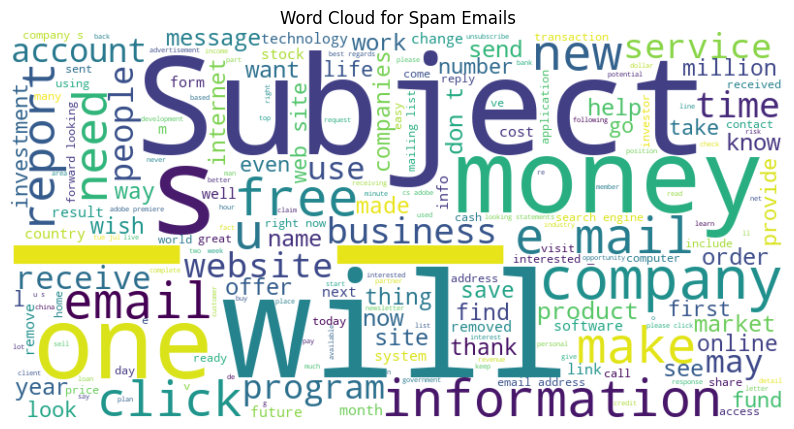

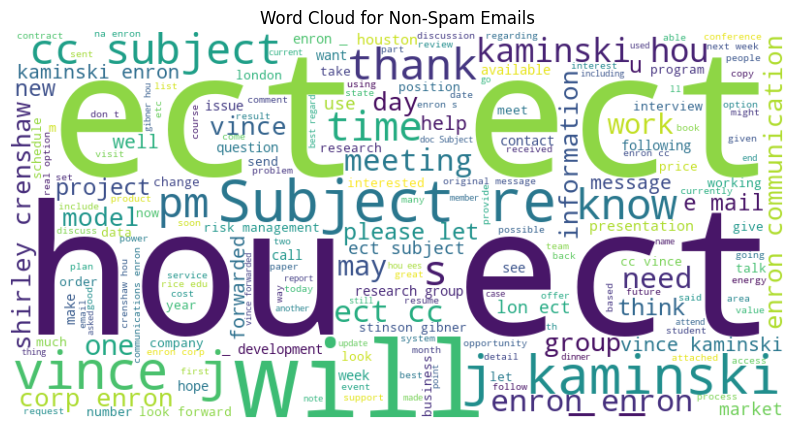

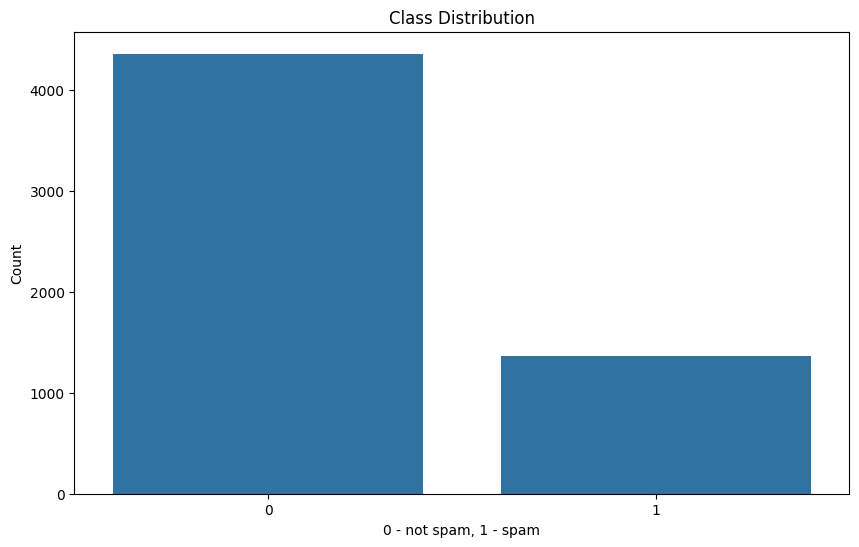

In [9]:
dataset.explore()

In [10]:
vectorizer = Vectorizer(
    vectorizer="standard",
    sampling_strategy="combined",  # expected valies: combined,  oversample, undersample
)

In [11]:

model = Model(
    vectorizer=vectorizer,
    emails=dataset.emails,
    labels=dataset.labels,
    min_max_ratio=dataset.get_min_max_ratio,
    show=True,
    max_iter=10000,
    test_size=0.2,
    imbalance_threshold=0.09,
)

Classes count after resampling:
0    1078
1    1078
Name: count, dtype: int64


In [12]:
model.classifier_accuracy()

Accuracy: 97.56



In [13]:
model.classify_email(text="Buy now bitcoin super cheap great offer!!!")

Fitting the model.
Accuracy: 97.5567

Category: Spam Probability: 0.8301


(0.83008638786611, 'Spam')